<a href="https://colab.research.google.com/github/ArthurSampaio13/TimeSeries/blob/main/SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando as bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

# Data set de produção de doces

## 1. Leitura os dados

In [ ]:
dados = pd.read_csv('/content/candy_production.csv')

## 2. Renomenado as colunas

In [ ]:
dados = dados.rename(columns={'observation_date': 'data', 'IPG3113N':'producao'})

## 3. Convertendo para tipo data e colocando como index

In [ ]:
dados['data'] = pd.to_datetime(dados['data'])

In [ ]:
dados = dados.set_index('data')

## 4. Breve visualização dos dados

In [ ]:
dados.head(10), dados.tail(10)

(            producao
 data                
 1972-01-01   85.6945
 1972-02-01   71.8200
 1972-03-01   66.0229
 1972-04-01   64.5645
 1972-05-01   65.0100
 1972-06-01   67.6467
 1972-07-01   69.0429
 1972-08-01   70.8370
 1972-09-01   75.0462
 1972-10-01  106.9289,
             producao
 data                
 2016-11-01  116.8431
 2016-12-01  116.4535
 2017-01-01  109.4666
 2017-02-01  113.4661
 2017-03-01  105.2245
 2017-04-01  107.4288
 2017-05-01  101.9209
 2017-06-01  104.2022
 2017-07-01  102.5861
 2017-08-01  114.0613)

> Os dados vão de 1972 até 2017

In [ ]:
dados.describe()

,producao
count,548.000000
mean,100.662524
std,18.052931
min,50.668900
25%,87.862475
50%,102.278550
75%,114.691900
max,139.915300


> Um mínimo de 50 e um máximo de 139 unidades de medida
- Uma média de 100

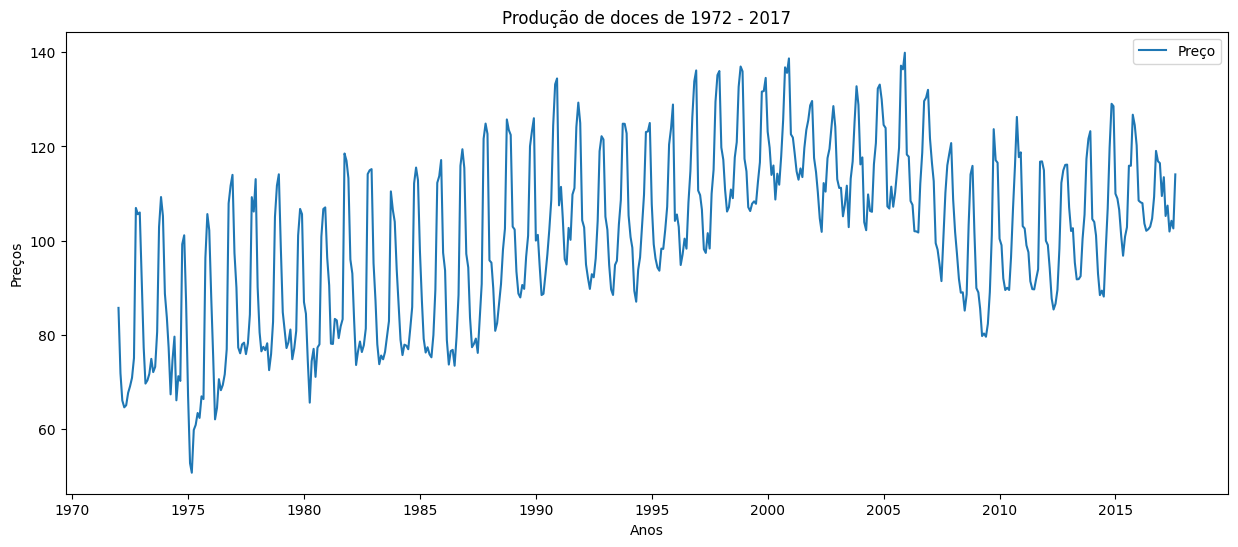

In [ ]:
plt.title('Produção de doces de 1972 - 2017')
plt.plot(dados, label='Preço')
plt.xlabel('Anos');
plt.ylabel('Preços');
plt.legend(loc='best')
plt.show()

> Interpretação dos resultados:
- É possível observar a sazonalidade
- É possível observar a tendência
- A Series não é estacionária

## 5. Decomposição da Series para observer tendência e sazonalidade

In [ ]:
resultado = seasonal_decompose(dados, model='multiplicative')

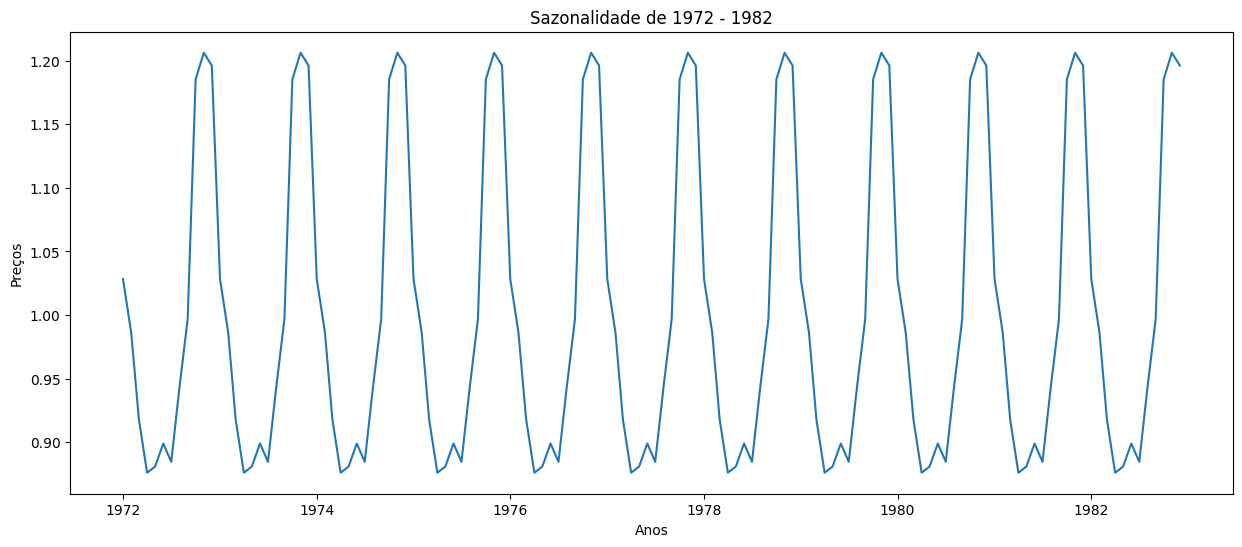

In [ ]:
plt.title('Sazonalidade de 1972 - 1982')
plt.plot(resultado.seasonal['1972':'1982'])
plt.xlabel('Anos');
plt.ylabel('Preços');
plt.show()

> Interpretação dos resultados:
- Possível observar grandes picos em dois períodos do ano: logo antes do fim do ano e no meio.

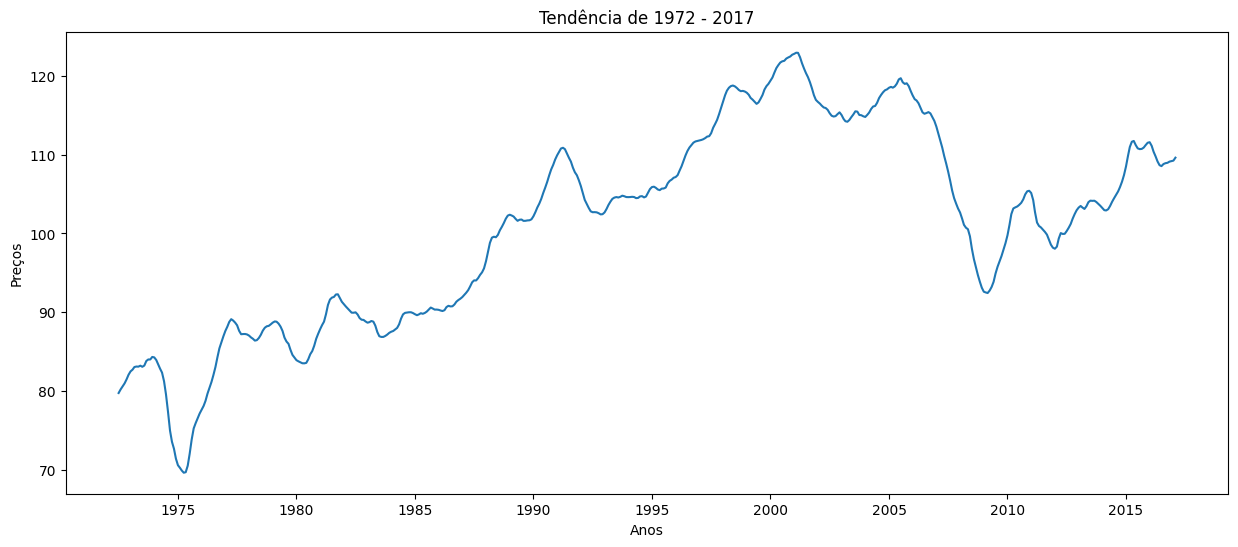

In [ ]:
plt.title('Tendência de 1972 - 2017')
plt.plot(resultado.trend)
plt.xlabel('Anos');
plt.ylabel('Preços');
plt.show()

> Interpretação dos resultados:
- Possível observar uma tendência crescente ao longo dos anos

# 6. Split em treino e teste

In [ ]:
train, test = dados.loc['1972':'2008'], dados.loc['2009':]

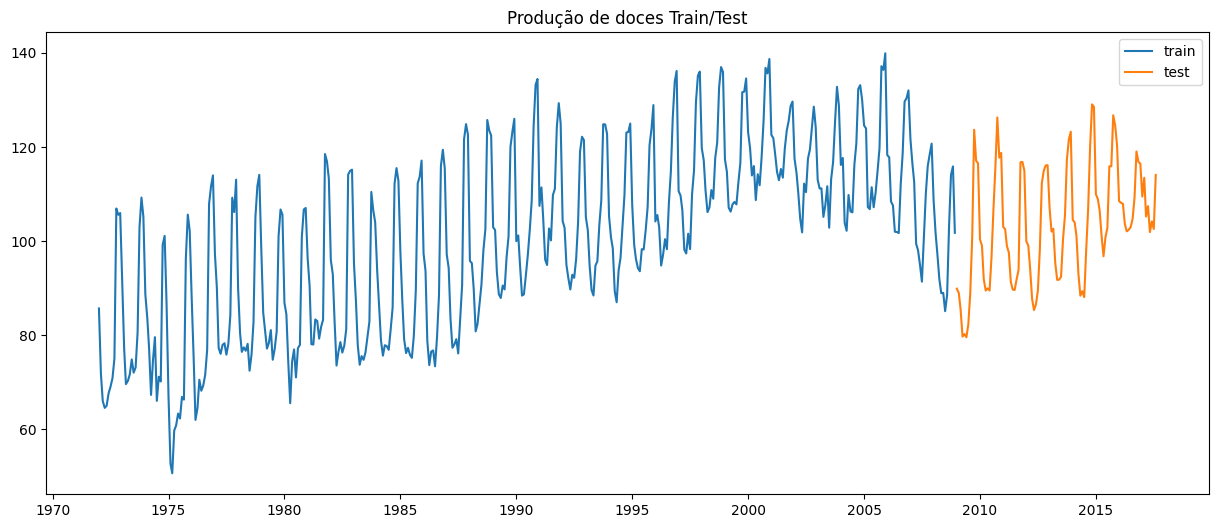

In [ ]:
plt.title('Produção de doces Train/Test')
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.legend(loc='best')
plt.show()

## 7. Gráficos PACF e ACF

> Os gráficos ACF mostram a correlação entre observações em diferentes defasagens, ajudando a identificar padrões temporais na série. Os gráficos PACF isolam a correlação direta entre observações, excluindo o efeito das defasagens intermediárias, auxiliando na escolha de modelos de séries temporais.

In [ ]:
def acf_pacf(x, qtd_lag):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=qtd_lag, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=qtd_lag, ax=ax2)
    plt.show()

## 8. Verificando a estacionaridade com Adfuller

> Verificar se os dados temporais são estacionários (estão em torno da média) ou não

Para essa verificação usaremos o teste de hipóteses, onde escolhemos uma hipótese para ser nula e tentamos rejeitar ela. O algoritmo que usaremos para testar a hipótese é o `ADF` (Augmented Dickey-Fuller) que é um método estatístico

Nesse caso, a hipótese nula é: série temporal não é estacionária

In [ ]:
def teste_estacionaria(serie):

  p_value = adfuller(serie)[1]

  print(p_value)

  if p_value < 0.05:
    print("Série estacionaria")

  else:
    print("Série não estacionaria")

teste_estacionaria(train)

0.47896098663008596
Série não estacionaria


> Interpretação do resultado:

Como o valor de `p-value` foi superior a 0.05, falhamos em rejeitar a hipótese nula usando o teste ADF e falhando em rejeitar a hipótese nula, temos que aceitar que **a série temporal não é estacionária**

Obs. Quanto mais próximo de 0, devemos aceitar a hipótese nula e quanto mais perto de 1, rejeitar

## 9. Analisando os valores de `p, d, q`

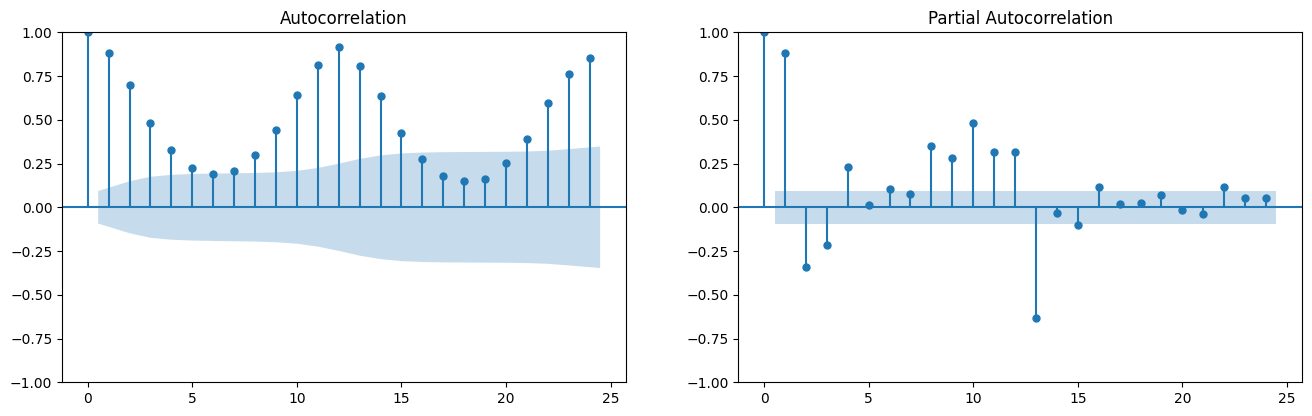

In [ ]:
acf_pacf(train, 24)

> Valor do `p`
- Os valores podem ser: [0, 1, 2, 3, 4]

> Valor do `q`
- Os valores podems ser: [0, 1, 2, 3, 4, 5]

> Valor de `d`


In [ ]:
teste_estacionaria(train.diff(1).diff(1).dropna())

0.0
Série estacionaria


> Valor de `P`
- Os valores podem ser: [0, 1, 2]

> Valor de `Q`

Os valores podem ser: [0, 1, 2]

> Valor de `D`
- Os valores podem ser: [0, 1]

## 10. Gridsearch para encontrar os melhores valores de `p, q, d` e `P, D, Q`




In [ ]:
p_values = [1, 2, 3, 4]
d_values = [1, 2]
q_values = [1, 2, 3, 4, 5]

P = [0, 1, 2]
D = [0, 1]
Q = [0, 1, 2]
m = 12

In [ ]:
parameters = product(p_values, d_values, q_values, P, D, Q)

In [ ]:
best_aic = float("inf")
best_params = None

for param in parameters:
    try:
        model = SARIMAX(train,
                        order=(param[0], param[1], param[2]),
                        seasonal_order=(param[3], param[4], param[5], m))

        results = model.fit()

        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
    except:
        continue


print("Melhores parâmetros encontrados para o order:", best_params[:3])
print("Melhores parâmetros encontrados para o seasonal order:", best_params[3:])

## 11. Criando o modelo com os parâmetros encontrados

In [ ]:
model = SARIMAX(train,
                order = (3, 1, 3),
                seasonal_order=(1, 0, 2, 12)
                ).fit()

## 12. Fazendo a previsão nos dados de `treino`

In [ ]:
train_prev = model.predict()
test_prev = model.forecast(len(test))

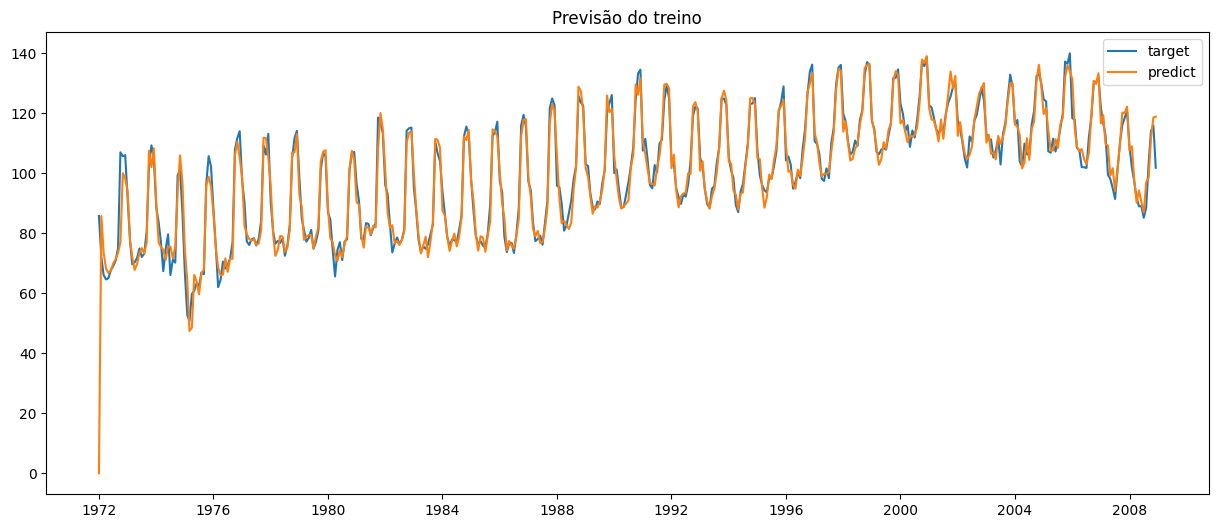

In [ ]:
plt.title('Previsão do treino')
plt.plot(train, label = 'target')
plt.plot(train_prev, label = 'predict')
plt.legend(loc='best')
plt.show()

## > **Taxa de erro**

In [ ]:
print(round(MAPE(train.producao, train_prev), 2), '%')

0.03 %


## Verificando o ruído da série

In [ ]:
ruido = train.producao - train_prev

<Axes: xlabel='data'>

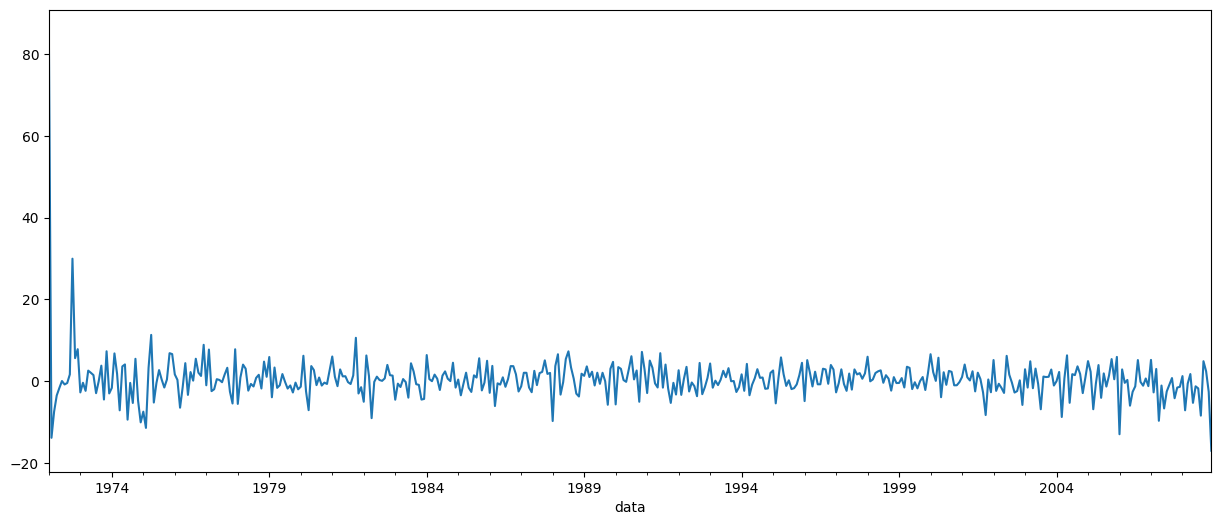

In [ ]:
ruido.plot()

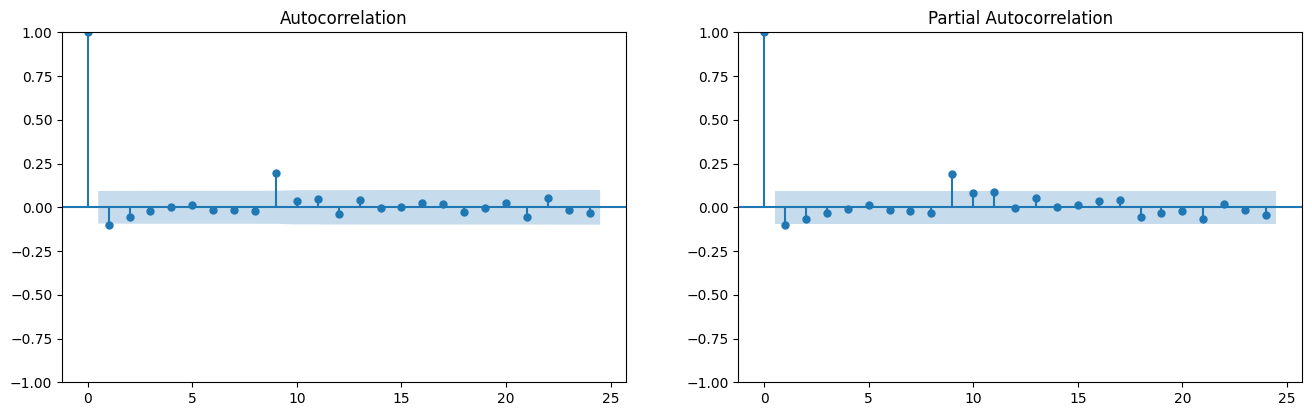

In [ ]:
acf_pacf(ruido, 24)

## 13. Fazendo a previsão nos dados de `teste`

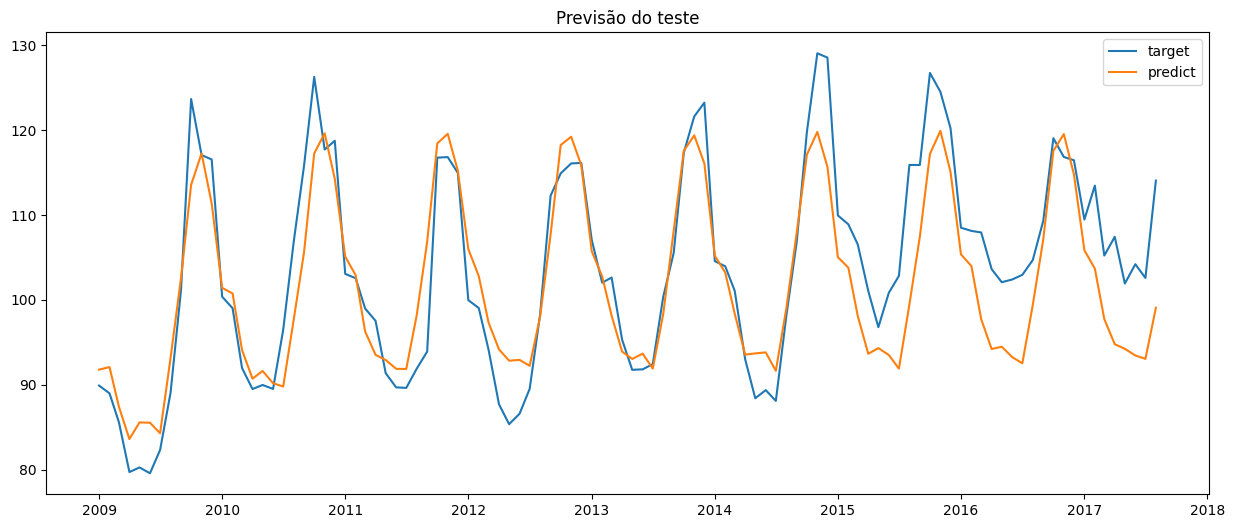

In [ ]:
plt.title('Previsão do teste')
plt.plot(test, label = 'target')
plt.plot(test_prev, label = 'predict')
plt.legend(loc='best')
plt.show()

## > **Taxa de erro**

In [ ]:
print(round(MAPE(test.producao, test_prev), 2), '%')

0.04 %


# AirPassengers

## 1. Leitura dos dados

In [ ]:
dados = pd.read_csv('/content/AirPassengers.csv', index_col = 0, parse_dates=True)

## 2. Renomeando coluna Passengers

In [ ]:
dados = dados.rename(columns={'#Passengers': 'Passangers'})

## 3. Breve visualização dos dados

In [ ]:
dados.head(10), dados.tail(10)

(            Passangers
 Month                 
 1949-01-01         112
 1949-02-01         118
 1949-03-01         132
 1949-04-01         129
 1949-05-01         121
 1949-06-01         135
 1949-07-01         148
 1949-08-01         148
 1949-09-01         136
 1949-10-01         119,
             Passangers
 Month                 
 1960-03-01         419
 1960-04-01         461
 1960-05-01         472
 1960-06-01         535
 1960-07-01         622
 1960-08-01         606
 1960-09-01         508
 1960-10-01         461
 1960-11-01         390
 1960-12-01         432)

> Os dados vão de 1949 até 1960

In [ ]:
dados.describe()

,Passangers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


> Um mínimo de 104 e um máximo de 622
- Uma média de 280

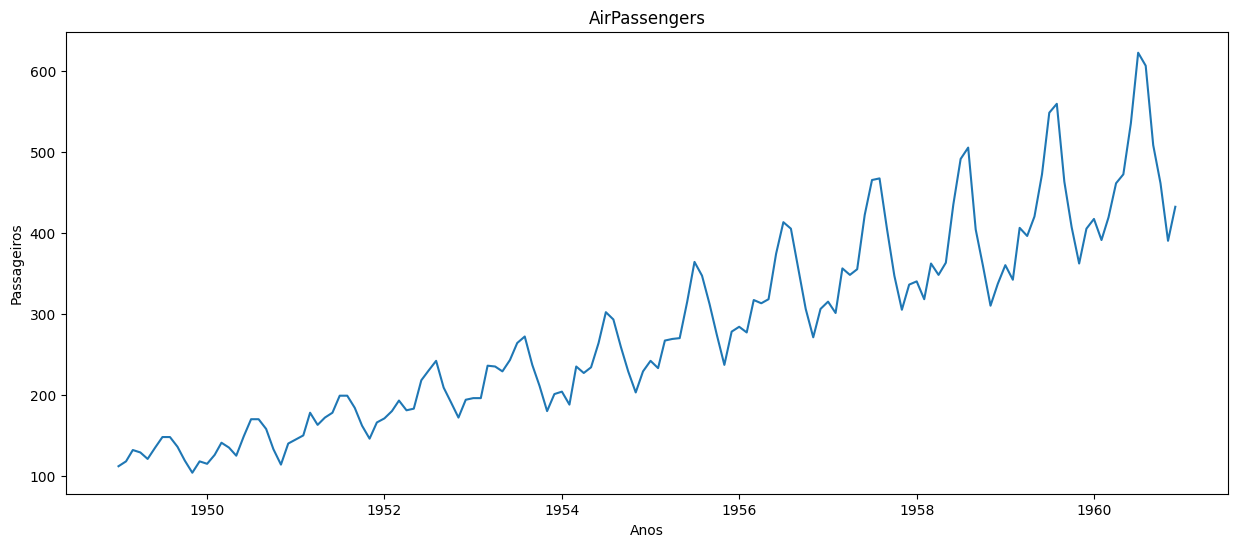

In [ ]:
plt.title('AirPassengers')
plt.plot(dados)
plt.xlabel('Anos')
plt.ylabel('Passageiros')
plt.show()

> Interpretação dos resultados:
- Há tendência
- Há sazonalidade
- Como a sazonalidade aumenta conforme a tendência, há fortes indícios de que a série seja multiplicativa.
- Como há tendência e sazonalidade, a série não é estacionária.

## 4. Observando tendência e sazonalidade

In [ ]:
resultado = seasonal_decompose(dados, model='multiplicative')

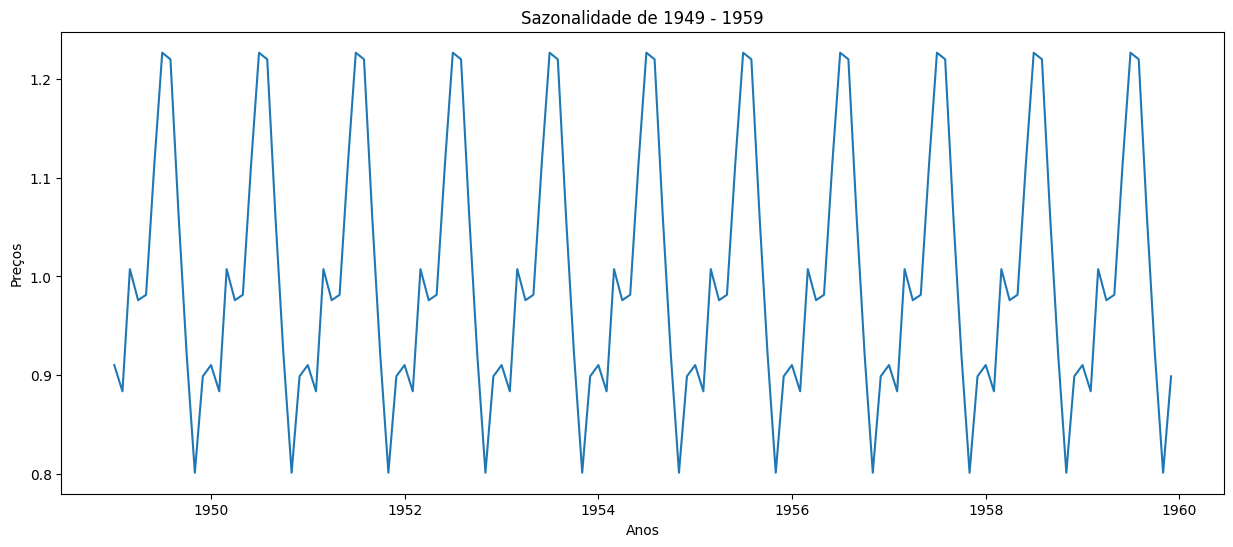

In [ ]:
plt.title('Sazonalidade de 1949 - 1959')
plt.plot(resultado.seasonal['1949':'1959'])
plt.xlabel('Anos');
plt.ylabel('Preços');
plt.show()

> Interpretação dos resultados:
- Possível observar grandes picos em dois períodos do ano: no começo e no meio.

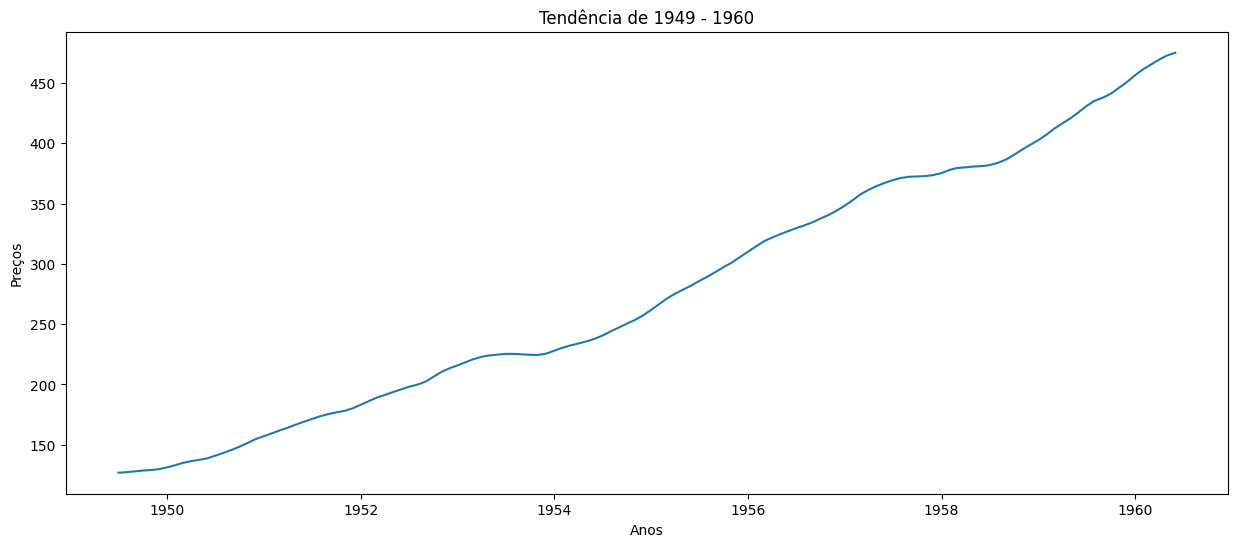

In [ ]:
plt.title('Tendência de 1949 - 1960')
plt.plot(resultado.trend)
plt.xlabel('Anos');
plt.ylabel('Preços');
plt.show()

> Interpretação dos resultados:
- Possível observar uma tendência crescente ao longo dos anos

# 5. Split treino e teste

In [ ]:
train, test = dados.loc['1949':'1957'], dados.loc['1958':]

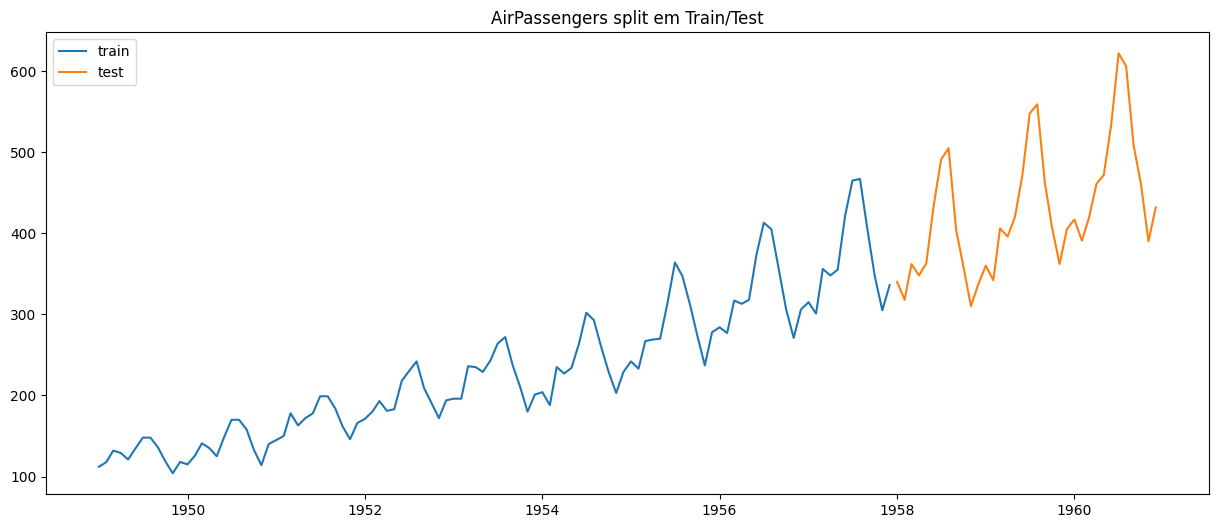

In [ ]:
plt.title('AirPassengers split em Train/Test')
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.legend(loc='best')
plt.show()

## 6. Verificando a estacionaridade com Adfuller

> Verificar se os dados temporais são estacionários (estão em torno da média) ou não

Para essa verificação usaremos o teste de hipóteses, onde escolhemos uma hipótese para ser nula e tentamos rejeitar ela. O algoritmo que usaremos para testar a hipótese é o `ADF` (Augmented Dickey-Fuller) que é um método estatístico

Nesse caso, a hipótese nula é: série temporal não é estacionária

In [ ]:
teste_estacionaria(train)

0.9942931644042374
Série não estacionaria


> Interpretação do resultado:

Como o valor de `p-value` foi superior a 0.05, falhamos em rejeitar a hipótese nula usando o teste ADF e falhando em rejeitar a hipótese nula, temos que aceitar que **a série temporal não é estacionária**

Obs. Quanto mais próximo de 0, devemos aceitar a hipótese nula e quanto mais perto de 1, rejeitar

## 7. Criando o modelo

### Analisando os valores de `p, d, q`

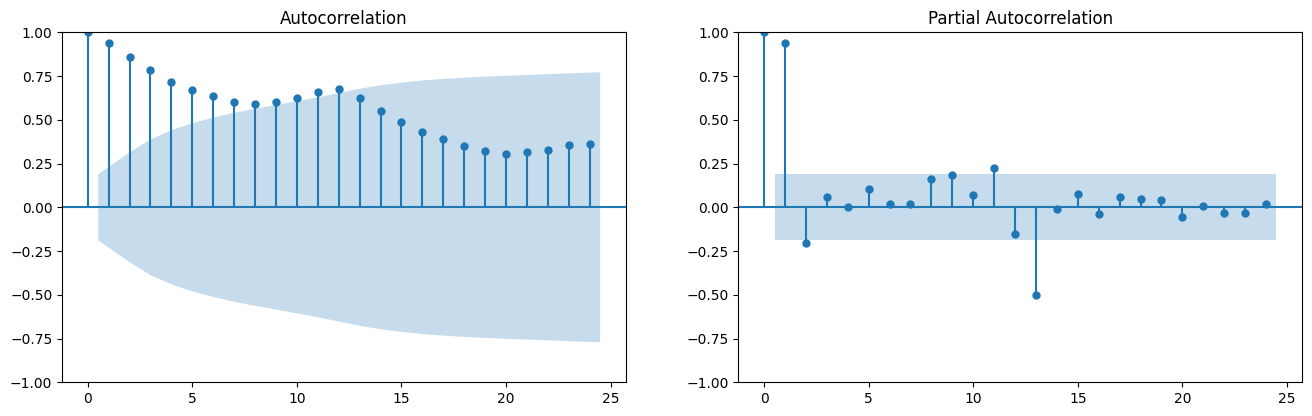

In [ ]:
acf_pacf(train, 24)

> Valor do `p`
- Os valores podem ser: [0, 1, 2]

> Valor do `q`
- Os valores podems ser: [0, 1, .. ,12]

> Valor de `d`


In [ ]:
teste_estacionaria(train.diff(1).diff(1).dropna())

2.2447076694533984e-10
Série estacionaria


> Valor de `P`
- Os valores podem ser: [0, 1, 2, 3]

> Valor de `Q`

Os valores podem ser: [0, 1]

> Valor de `D`
- Os valores podem ser: [0, 1]

## 8. Gridsearch para encontrar os melhores valores de p, q, d




In [ ]:
p_values = [1, 2]
d_values = [1, 2]
q_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

P = [0, 1, 2, 3]
D = [0, 1]
Q = [0, 1]
m = 12

In [ ]:
parameters = product(p_values, d_values, q_values, P, D, Q)

In [ ]:
best_aic = float("inf")
best_params = None

for param in parameters:
    try:
        model = SARIMAX(train,
                        order=(param[0], param[1], param[2]),
                        seasonal_order=(param[3], param[4], param[5], m))

        results = model.fit()

        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
    except:
        continue

print("Melhores parâmetros encontrados para o order:", best_params[:3])

print("Melhores parâmetros encontrados para o seosanal order:", best_params[3:])

## 9. Criando o modelo

In [ ]:
model = SARIMAX(train,
                order = (2, 1, 9),
                seasonal_order=(3, 0, 1, 12)).fit()

## 10. Fazendo a previsão nos dados de `treino`

In [ ]:
train_prev = model.predict()
test_prev = model.forecast(len(test))

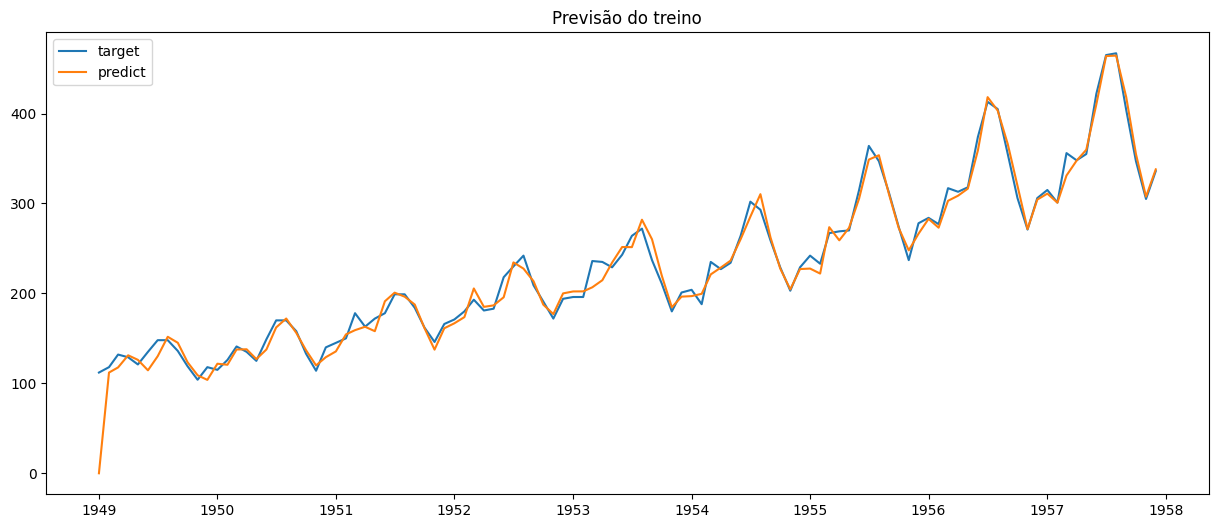

In [ ]:
plt.title('Previsão do treino')
plt.plot(train, label = 'target')
plt.plot(train_prev, label = 'predict')
plt.legend(loc='best')
plt.show()

## > **Taxa de erro**

In [ ]:
print(round(MAPE(train.Passangers, train_prev), 2), '%')

0.05 %


## Verificando o ruído da série em treino

In [ ]:
ruido = train.Passangers - train_prev

<Axes: xlabel='Month'>

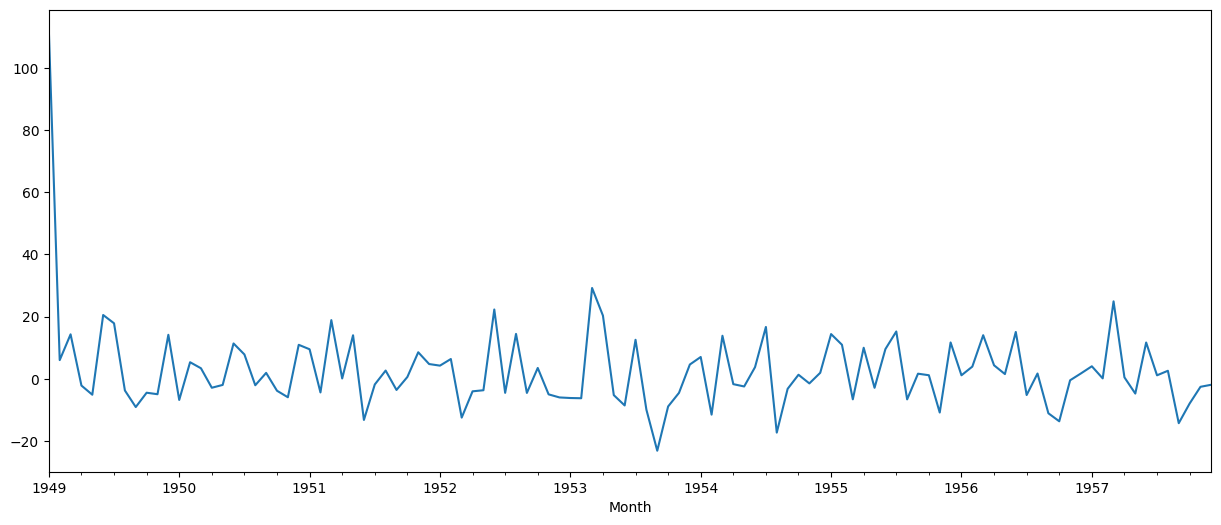

In [ ]:
ruido.plot()

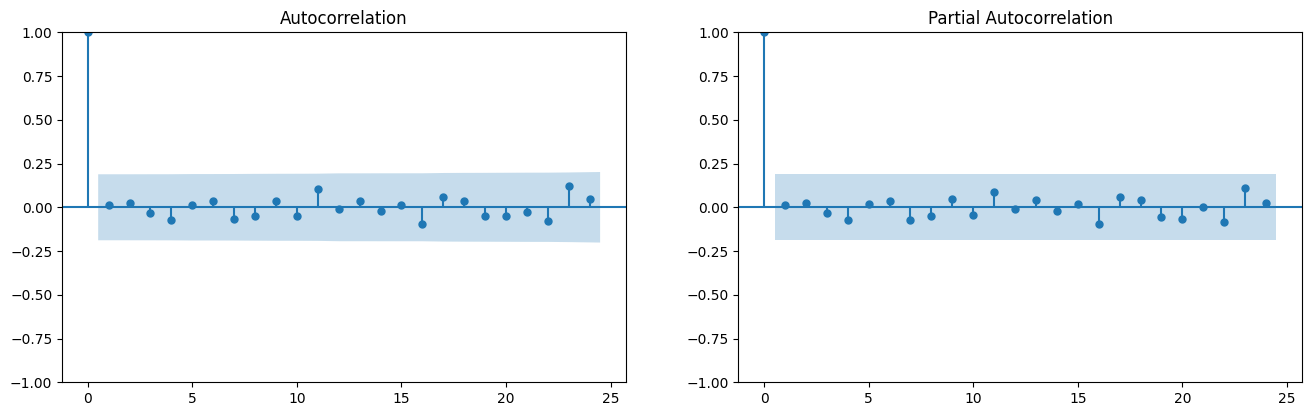

In [ ]:
acf_pacf(ruido, 24)

## 10. Fazendo a previsão nos dados de `teste`

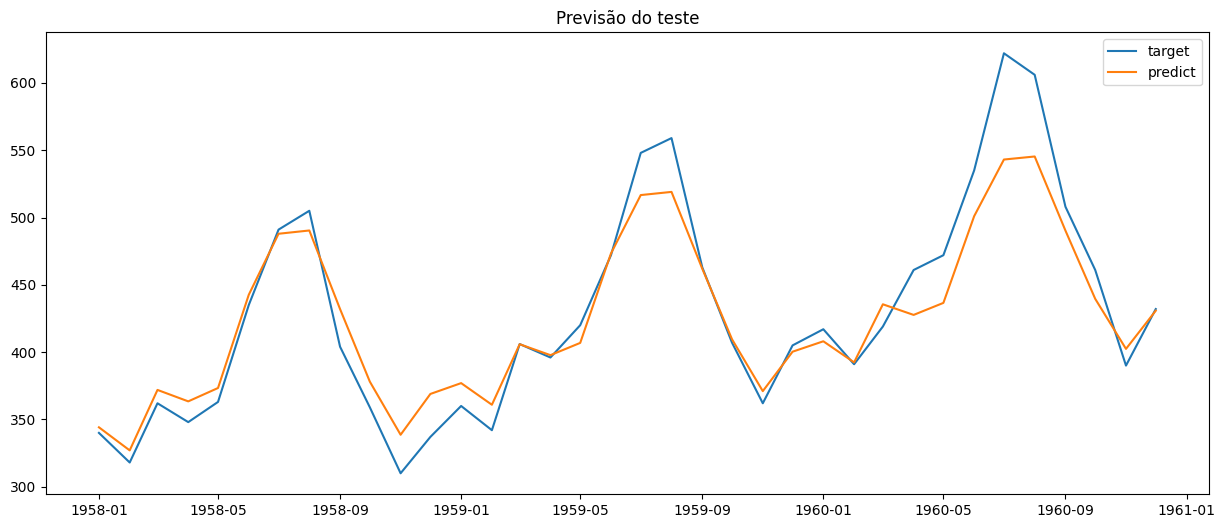

In [ ]:
plt.title('Previsão do teste')
plt.plot(test, label = 'target')
plt.plot(test_prev, label = 'predict')
plt.legend(loc='best')
plt.show()

## > **Taxa de erro**

In [ ]:
print(round(MAPE(test.Passangers, test_prev), 2), '%')

0.04 %
